# Batting Analysis of The World Cup 2019
> Inspired by some graphics made by [@SAAdvantage](https://twitter.com/SAAdvantage)

I have been looking into the different metrics that can be used to define a batsman and his/her performance recently. I cam across a brilliant thread on Twitter about the PSL by SAAdvantage and the different metrics that he was plotting to try and display the strengths and weaknesses of a batsman in the modern T20 game. 

In [23]:
# Imports
%matplotlib inline
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

I am going to focus initially on the batting stats from the ICC Cricket World Cup 2019.  

You can find the summary stats for the competition on ESPNCricInfo; the URL for the summary page that shows the overall batting stats for the top 50 highest scoring batsman at ICC Cricket World Cup 2019 is defined below.

In [2]:
url = 'http://stats.espncricinfo.com/ci/engine/records/batting/most_runs_career.html?id=12357;type=tournament'

# Build the soup object
soup = BeautifulSoup(requests.get(url).text, features="html.parser")

We want to isolate the table that contains the numbers that we are interested in. This is done by looking for the `<caption>`, and then finding the parent `<table>` tags that have a particular class that can be found by looking at the source code of the page. 

In [3]:
for caption in soup.find_all('caption'):
    if caption.get_text() == 'Most runs':
        main_table = caption.find_parent(
            'table', {'class': 'engineTable'})

We then just clean up the output by finding the headers, and then looping through the rows before building the whole thing into an easy to use table: `df_raw`. 

In [4]:
columns = [header.get_text() for header in main_table.find('thead').find_all('tr')[0].find_all('th')]
rows = []

for innings in [row for row in main_table.find('tbody').find_all('tr')]:
    rows.append([stat.get_text() for stat in innings.find_all('td')])
    
df_raw = pd.DataFrame(rows, columns=columns).apply(pd.to_numeric, errors='ignore')

In [5]:
df_raw.head()

,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s
0,RG Sharma (INDIA),9,9,1,648,140,81.00,659,98.33,5,1,0,67,14
1,DA Warner (AUS),10,10,1,647,166,71.88,724,89.36,3,3,0,66,8
2,Shakib Al Hasan (BDESH),8,8,1,606,124*,86.57,631,96.03,2,5,0,60,2
3,KS Williamson (NZ),10,9,2,578,148,82.57,771,74.96,2,2,0,50,3
4,JE Root (ENG),11,11,2,556,107,61.77,621,89.53,2,3,0,48,2


We don't need all the columns to work out what we are going to work out. We can use just those defined below. 

In [6]:
required_columns = ['Player','Runs', 'BF','SR','4s','6s']
df_trim = df_raw.loc[:, required_columns].copy()

I'm going to define some cleaner functions just to handle the 'Player' column and split out the country into its own column. 

In [7]:
def country(player_string):
    regex = re.compile(r'.* \(([A-Z]*)\)')
    return(regex.search(player_string).group(1))

def clean_player(player_string):
    regex = re.compile(r'([a-zA-Z ]*)\s\([A-Z]*\)')
    return(regex.search(player_string).group(1))

In [8]:
df_trim['Country'] = df_trim.Player.apply(country)
df_trim['Player'] = df_trim.Player.apply(clean_player)

In [9]:
df_trim.head()

,Player,Runs,BF,SR,4s,6s,Country
0,RG Sharma,648,659,98.33,67,14,INDIA
1,DA Warner,647,724,89.36,66,8,AUS
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH
3,KS Williamson,578,771,74.96,50,3,NZ
4,JE Root,556,621,89.53,48,2,ENG


We then want to add the columns about boundaries and power hitting that are going to let us create the visualisations that we are interested in. 

In [10]:
df_trim['BoundaryRuns'] = df_trim['4s'] * 4 + df_trim['6s'] * 6
df_trim['NonBoundaryRuns'] = df_trim['Runs'] - df_trim['BoundaryRuns']
df_trim['TotalBoundaries'] = df_trim['4s'] + df_trim['6s']
df_trim['NonBoundaryBalls'] = df_trim['BF'] - df_trim['TotalBoundaries']
df_trim['Boundary %'] = round(df_trim['TotalBoundaries'] / df_trim['BF'] * 100, 2)
df_trim['NonBoundaryStrikeRate'] = round(df_trim['NonBoundaryRuns'] / df_trim['NonBoundaryBalls'] * 100, 2)

In [11]:
df_trim

,Player,Runs,BF,SR,4s,6s,Country,BoundaryRuns,NonBoundaryRuns,TotalBoundaries,NonBoundaryBalls,Boundary %,NonBoundaryStrikeRate
0,RG Sharma,648,659,98.33,67,14,INDIA,352,296,81,578,12.29,51.21
1,DA Warner,647,724,89.36,66,8,AUS,312,335,74,650,10.22,51.54
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH,252,354,62,569,9.83,62.21
3,KS Williamson,578,771,74.96,50,3,NZ,218,360,53,718,6.87,50.14
4,JE Root,556,621,89.53,48,2,ENG,204,352,50,571,8.05,61.65
5,JM Bairstow,532,573,92.84,67,11,ENG,334,198,78,495,13.61,40.00
6,AJ Finch,507,497,102.01,47,18,AUS,296,211,65,432,13.08,48.84
7,Babar Azam,474,540,87.77,50,2,PAK,212,262,52,488,9.63,53.69
8,BA Stokes,465,499,93.18,38,11,ENG,218,247,49,450,9.82,54.89
9,JJ Roy,443,384,115.36,51,12,ENG,276,167,63,321,16.41,52.02


## Visualisations

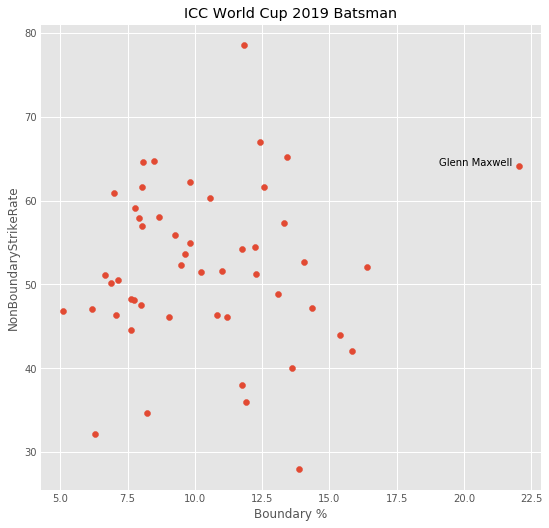

In [61]:
maxwell = df_trim[df_trim['Player'] == 'GJ Maxwell']

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x = df_trim['Boundary %'], 
           y = df_trim['NonBoundaryStrikeRate'])
ax.set_title('ICC World Cup 2019 Batsman')
ax.set_ylabel('NonBoundaryStrikeRate')
ax.set_xlabel('Boundary %')
ax.text(x = maxwell['Boundary %'], 
        y = maxwell['NonBoundaryStrikeRate'], 
        s='Glenn Maxwell  ',
        horizontalalignment='right')
plt.show()